### Before we get the data and start exploring it, let's import all required libraries

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
!pip install geopy
#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import k-means from clustering stage
from sklearn.cluster import KMeans
! pip install folium==0.5.0
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Libraries imported.


### My variables

In [3]:
CLIENT_ID = 'A41PM1K3CFCMCRVDJLHBYH2BOZ2OMQOXC21NTQ0LZWBW05EI' # your Foursquare ID
CLIENT_SECRET = '0QG5HOKS5RJ41Z0LRD0WLU2WBQQB1YZXXOZB4KEPIIZ43RWY' # your Foursquare Secret
ACCESS_TOKEN = 'WOHJ44YIICWSXCC5P4HUTYPN5KCFDWP1RQBWFQN5ZA2T0BAN' # your FourSquare Access Token
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: A41PM1K3CFCMCRVDJLHBYH2BOZ2OMQOXC21NTQ0LZWBW05EI
CLIENT_SECRET:0QG5HOKS5RJ41Z0LRD0WLU2WBQQB1YZXXOZB4KEPIIZ43RWY


### Now let's define the functions we are going to use later in this project

In [4]:
def geo_location(address):
    # get geo location of address
    geolocator = Nominatim(user_agent="foursquare_agent")
    location = geolocator.geocode(address)
    latitude = location.latitude
    longitude = location.longitude
    return latitude,longitude

def get_venues(lat,lng):
    #set variables
    radius=400
    LIMIT=100
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
    # get all the data
    results = requests.get(url).json()
    venue_data=results['response']['groups'][0]['items']
    venue_details=[]
    for row in venue_data:
        try:
            venue_id=row['venue']['id']
            venue_name=row['venue']['name']
            venue_category=row['venue']['categories'][0]['name']
            venue_details.append([venue_id,venue_name,venue_category])
        except KeyError:
            pass
    column_names=['ID','Name','Category']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df

def get_venue_details(venue_id):
    #url to fetch data from foursquare api
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
    # get all the data
    results = requests.get(url).json()
    print(results)
    venue_data=results['response']['venue']
    venue_details=[]
    try:
        venue_id=venue_data['id']
        venue_name=venue_data['name']
        venue_likes=venue_data['likes']['count']
        venue_rating=venue_data['rating']
        venue_tips=venue_data['tips']['count']
        venue_details.append([venue_id,venue_name,venue_likes,venue_rating,venue_tips])
    except KeyError:
        pass
    column_names=['ID','Name','Likes','Rating','Tips']
    df = pd.DataFrame(venue_details,columns=column_names)
    return df


def get_new_york_data():
    url='https://cocl.us/new_york_dataset'
    resp=requests.get(url).json()
    # all data is present in features label
    features=resp['features']
    # define the dataframe columns
    column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 
    # instantiate the dataframe
    new_york_data = pd.DataFrame(columns=column_names)
    for data in features:
        borough = data['properties']['borough'] 
        neighborhood_name = data['properties']['name']
        neighborhood_latlon = data['geometry']['coordinates']
        neighborhood_lat = neighborhood_latlon[1]
        neighborhood_lon = neighborhood_latlon[0]
        new_york_data = new_york_data.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    return new_york_data

### Now let's use the above codes to get our initial NYC data

In [5]:
ny_data = get_new_york_data()
ny_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [6]:

ny_data.shape

(306, 4)

### Initial Data Analysis

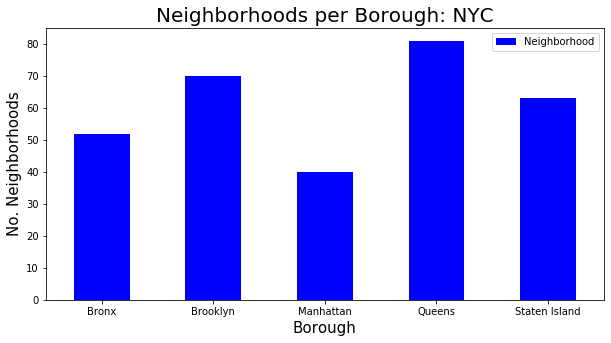

In [7]:
clr = "blue"
ny_data.groupby('Borough')['Neighborhood'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Neighborhoods per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. Neighborhoods',fontsize = 15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

### Let's analyze further and see how many Peruvian restaurants there are in each neighborhood and borough. After it, graph the results.

In [8]:
# queens has most neighborhoods
# prepare neighborhood list that contains japanese restaurants
column_names=['Borough', 'Neighborhood', 'ID','Name']
peruvian_rest_ny=pd.DataFrame(columns=column_names)
count=1
for row in ny_data.values.tolist():
    Borough, Neighborhood, Latitude, Longitude=row
    venues = get_venues(Latitude,Longitude)
    peruvian_restaurants=venues[venues['Category']=='Peruvian Restaurant']   
    print('(',count,'/',len(ny_data),')','Peruvian Restaurants in '+Neighborhood+', '+Borough+':'+str(len(peruvian_restaurants)))
    print(row)
    for resturant_detail in peruvian_restaurants.values.tolist():
        id, name , category=resturant_detail
        peruvian_rest_ny = peruvian_rest_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name
                                               }, ignore_index=True)
    count+=1

( 1 / 306 ) Peruvian Restaurants in Wakefield, Bronx:0
['Bronx', 'Wakefield', 40.89470517661, -73.84720052054902]
( 2 / 306 ) Peruvian Restaurants in Co-op City, Bronx:0
['Bronx', 'Co-op City', 40.87429419303012, -73.82993910812398]
( 3 / 306 ) Peruvian Restaurants in Eastchester, Bronx:0
['Bronx', 'Eastchester', 40.887555677350775, -73.82780644716412]
( 4 / 306 ) Peruvian Restaurants in Fieldston, Bronx:0
['Bronx', 'Fieldston', 40.89543742690383, -73.90564259591682]
( 5 / 306 ) Peruvian Restaurants in Riverdale, Bronx:0
['Bronx', 'Riverdale', 40.890834493891305, -73.9125854610857]
( 6 / 306 ) Peruvian Restaurants in Kingsbridge, Bronx:0
['Bronx', 'Kingsbridge', 40.88168737120521, -73.90281798724604]
( 7 / 306 ) Peruvian Restaurants in Marble Hill, Manhattan:0
['Manhattan', 'Marble Hill', 40.87655077879964, -73.91065965862981]
( 8 / 306 ) Peruvian Restaurants in Woodlawn, Bronx:0
['Bronx', 'Woodlawn', 40.89827261213805, -73.86731496814176]
( 9 / 306 ) Peruvian Restaurants in Norwood, B

( 67 / 306 ) Peruvian Restaurants in Carroll Gardens, Brooklyn:0
['Brooklyn', 'Carroll Gardens', 40.680540231076485, -73.99465372828006]
( 68 / 306 ) Peruvian Restaurants in Red Hook, Brooklyn:0
['Brooklyn', 'Red Hook', 40.676253230250886, -74.0127589747356]
( 69 / 306 ) Peruvian Restaurants in Gowanus, Brooklyn:0
['Brooklyn', 'Gowanus', 40.673931143187154, -73.99444087145339]
( 70 / 306 ) Peruvian Restaurants in Fort Greene, Brooklyn:0
['Brooklyn', 'Fort Greene', 40.68852726018977, -73.97290574369092]
( 71 / 306 ) Peruvian Restaurants in Park Slope, Brooklyn:0
['Brooklyn', 'Park Slope', 40.67232052268197, -73.97705030183924]
( 72 / 306 ) Peruvian Restaurants in Cypress Hills, Brooklyn:0
['Brooklyn', 'Cypress Hills', 40.68239101144211, -73.87661596457296]
( 73 / 306 ) Peruvian Restaurants in East New York, Brooklyn:0
['Brooklyn', 'East New York', 40.669925700847045, -73.88069863917366]
( 74 / 306 ) Peruvian Restaurants in Starrett City, Brooklyn:0
['Brooklyn', 'Starrett City', 40.64758

( 130 / 306 ) Peruvian Restaurants in Astoria, Queens:0
['Queens', 'Astoria', 40.76850859335492, -73.91565374304234]
( 131 / 306 ) Peruvian Restaurants in Woodside, Queens:0
['Queens', 'Woodside', 40.74634908860222, -73.90184166838284]
( 132 / 306 ) Peruvian Restaurants in Jackson Heights, Queens:2
['Queens', 'Jackson Heights', 40.75198138007367, -73.88282109164365]
( 133 / 306 ) Peruvian Restaurants in Elmhurst, Queens:0
['Queens', 'Elmhurst', 40.744048505122024, -73.88165622288388]
( 134 / 306 ) Peruvian Restaurants in Howard Beach, Queens:0
['Queens', 'Howard Beach', 40.65422527738487, -73.8381376460028]
( 135 / 306 ) Peruvian Restaurants in Corona, Queens:0
['Queens', 'Corona', 40.74238175015667, -73.85682497345258]
( 136 / 306 ) Peruvian Restaurants in Forest Hills, Queens:0
['Queens', 'Forest Hills', 40.72526378216503, -73.84447500788983]
( 137 / 306 ) Peruvian Restaurants in Kew Gardens, Queens:0
['Queens', 'Kew Gardens', 40.7051790354148, -73.82981905825703]
( 138 / 306 ) Peruv

( 196 / 306 ) Peruvian Restaurants in North Corona, Queens:0
['Queens', 'North Corona', 40.7540709990489, -73.85751790676447]
( 197 / 306 ) Peruvian Restaurants in Forest Hills Gardens, Queens:0
['Queens', 'Forest Hills Gardens', 40.7146110815117, -73.8410221123401]
( 198 / 306 ) Peruvian Restaurants in St. George, Staten Island:0
['Staten Island', 'St. George', 40.6449815710044, -74.07935312512797]
( 199 / 306 ) Peruvian Restaurants in New Brighton, Staten Island:0
['Staten Island', 'New Brighton', 40.64061455913511, -74.08701650516625]
( 200 / 306 ) Peruvian Restaurants in Stapleton, Staten Island:0
['Staten Island', 'Stapleton', 40.62692762538176, -74.07790192660066]
( 201 / 306 ) Peruvian Restaurants in Rosebank, Staten Island:0
['Staten Island', 'Rosebank', 40.61530494652761, -74.06980526716141]
( 202 / 306 ) Peruvian Restaurants in West Brighton, Staten Island:0
['Staten Island', 'West Brighton', 40.63187892654607, -74.1071817826561]
( 203 / 306 ) Peruvian Restaurants in Grymes H

( 256 / 306 ) Peruvian Restaurants in Emerson Hill, Staten Island:0
['Staten Island', 'Emerson Hill', 40.606794394801, -74.09776206972522]
( 257 / 306 ) Peruvian Restaurants in Randall Manor, Staten Island:0
['Staten Island', 'Randall Manor', 40.63563000681151, -74.09805062373887]
( 258 / 306 ) Peruvian Restaurants in Howland Hook, Staten Island:0
['Staten Island', 'Howland Hook', 40.63843283794795, -74.18622331749823]
( 259 / 306 ) Peruvian Restaurants in Elm Park, Staten Island:0
['Staten Island', 'Elm Park', 40.630146741193826, -74.1418167896889]
( 260 / 306 ) Peruvian Restaurants in Remsen Village, Brooklyn:0
['Brooklyn', 'Remsen Village', 40.652117451793494, -73.91665331978048]
( 261 / 306 ) Peruvian Restaurants in New Lots, Brooklyn:0
['Brooklyn', 'New Lots', 40.6627442796966, -73.88511776379292]
( 262 / 306 ) Peruvian Restaurants in Paerdegat Basin, Brooklyn:0
['Brooklyn', 'Paerdegat Basin', 40.63131755039667, -73.90233474295836]
( 263 / 306 ) Peruvian Restaurants in Mill Basin,

In [9]:
# Save the information so far to a .csv file due to limited calls on FourSquare
peruvian_rest_ny.to_csv('peruvian_rest_ny_tocsv1.csv')

In [10]:
peruvian_ny = pd.read_csv('peruvian_rest_ny_tocsv1.csv')
peruvian_rest_ny.tail(13)

,Borough,Neighborhood,ID,Name
0,Bronx,Mott Haven,4bb28791715eef3b9f5e85bb,Pio Pio
1,Manhattan,Upper West Side,4a7a543df964a5202ee91fe3,Flor de Mayo
2,Manhattan,Clinton,4b1b1f52f964a52074f823e3,Pio Pio
3,Queens,Jackson Heights,4b9ece55f964a520590337e3,Urubamba
4,Queens,Jackson Heights,514cae4ae4b08e5e6fb50538,Don Alex Restaurant
5,Queens,Sunnyside,51ec2df8498ee2a4dc8ee843,Don Pollo II
6,Queens,Rego Park,4ede24237ee5f354d5122374,Don Alex
7,Queens,Rego Park,4b37cf54f964a520924625e3,Cuzco Peru
8,Queens,Little Neck,52d1e8f4498e56474f235066,Lima 33 Restaurant
9,Staten Island,Concord,536eb74e498e9a6b05cc9939,Inca's Grill Peruvian Cuisine


In [11]:
peruvian_rest_ny.shape

(12, 4)

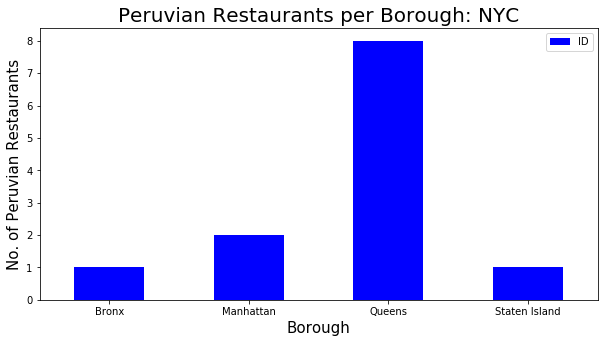

In [12]:

peruvian_rest_ny.groupby('Borough')['ID'].count().plot.bar(figsize=(10,5), color=clr)
plt.title('Peruvian Restaurants per Borough: NYC', fontsize = 20)
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('No. of Peruvian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

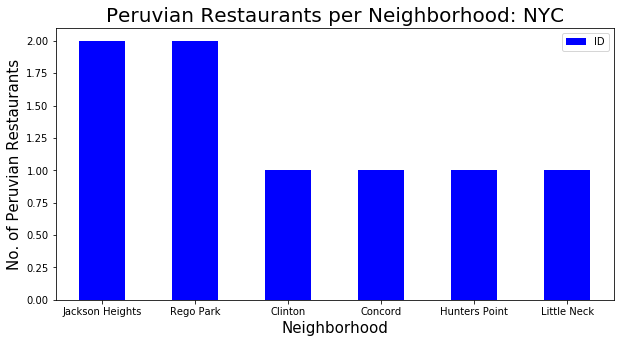

In [13]:
NOofNeigh = 6 # top number for graphing all the same past 6
peruvian_rest_ny.groupby('Neighborhood')['ID'].count().nlargest(NOofNeigh).plot.bar(figsize=(10,5), color=clr)
plt.title('Peruvian Restaurants per Neighborhood: NYC', fontsize = 20)
plt.xlabel('Neighborhood', fontsize = 15)
plt.ylabel('No. of Peruvian Restaurants', fontsize=15)
plt.xticks(rotation = 'horizontal')
plt.legend()
plt.show()

In [14]:
peruvian_rest_ny[peruvian_rest_ny['Neighborhood']=='Jackson Heights']

,Borough,Neighborhood,ID,Name
3,Queens,Jackson Heights,4b9ece55f964a520590337e3,Urubamba
4,Queens,Jackson Heights,514cae4ae4b08e5e6fb50538,Don Alex Restaurant


In [15]:
column_names=['Borough', 'Neighborhood', 'ID','Name','Likes','Rating','Tips']
peruvian_rest_stats_ny=pd.DataFrame(columns=column_names)
count=1
for row in peruvian_rest_ny.values.tolist():
    Borough,Neighborhood,ID,Name=row
    try:
        venue_details=get_venue_details(ID)
        print(venue_details)
        id,name,likes,rating,tips=venue_details.values.tolist()[0]
    except IndexError:
        print('No data available for id=',ID)
        # we will assign 0 value for these resturants as they may have been 
        #recently opened or details does not exist in FourSquare Database
        id,name,likes,rating,tips=[0]*5
    print('(',count,'/',len(peruvian_rest_ny),')','processed')
    peruvian_rest_stats_ny = peruvian_rest_stats_ny.append({'Borough': Borough,
                                                'Neighborhood': Neighborhood, 
                                                'ID': id,
                                                'Name' : name,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)
    count+=1
peruvian_rest_stats_ny.tail()

{'meta': {'code': 200, 'requestId': '604849c1511b4e7cb6712084'}, 'response': {'venue': {'id': '4bb28791715eef3b9f5e85bb', 'name': 'Pio Pio', 'contact': {'phone': '7184013300', 'formattedPhone': '(718) 401-3300'}, 'location': {'address': '264 Cypress Ave', 'crossStreet': 'at E 139th St', 'lat': 40.80604732187535, 'lng': -73.91418540969559, 'labeledLatLngs': [{'label': 'display', 'lat': 40.80604732187535, 'lng': -73.91418540969559}, {'label': 'entrance', 'lat': 40.806015, 'lng': -73.914084}], 'postalCode': '10454', 'cc': 'US', 'neighborhood': 'Mott Haven', 'city': 'Bronx', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['264 Cypress Ave (at E 139th St)', 'Bronx, NY 10454', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pio-pio/4bb28791715eef3b9f5e85bb', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/

{'meta': {'code': 200, 'requestId': '604849c1b2d4e616c5605f2c'}, 'response': {'venue': {'id': '4a7a543df964a5202ee91fe3', 'name': 'Flor de Mayo', 'contact': {'phone': '2127873388', 'formattedPhone': '(212) 787-3388'}, 'location': {'address': '484 Amsterdam Ave', 'crossStreet': 'btwn 83rd & 84th St.', 'lat': 40.785966049770074, 'lng': -73.9763123251348, 'labeledLatLngs': [{'label': 'display', 'lat': 40.785966049770074, 'lng': -73.9763123251348}, {'label': 'entrance', 'lat': 40.786025, 'lng': -73.976433}], 'postalCode': '10024', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['484 Amsterdam Ave (btwn 83rd & 84th St.)', 'New York, NY 10024', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/flor-de-mayo/4a7a543df964a5202ee91fe3', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/f

{'meta': {'code': 200, 'requestId': '604849c131e8773ab7960732'}, 'response': {'venue': {'id': '4b1b1f52f964a52074f823e3', 'name': 'Pio Pio', 'contact': {'phone': '2124592929', 'formattedPhone': '(212) 459-2929'}, 'location': {'address': '604 10th Ave', 'crossStreet': 'btwn W 43rd & W 44th St', 'lat': 40.76063594478618, 'lng': -73.99471374607128, 'labeledLatLngs': [{'label': 'display', 'lat': 40.76063594478618, 'lng': -73.99471374607128}], 'postalCode': '10036', 'cc': 'US', 'city': 'New York', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['604 10th Ave (btwn W 43rd & W 44th St)', 'New York, NY 10036', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/pio-pio/4b1b1f52f964a52074f823e3', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/peruvian_', 'suffix': '.png'}, 'primary': True}, {'id': '4bf58dd8d4898

{'meta': {'code': 200, 'requestId': '604849c15c85a33ad7211425'}, 'response': {'venue': {'id': '4b9ece55f964a520590337e3', 'name': 'Urubamba', 'contact': {'phone': '7186722224', 'formattedPhone': '(718) 672-2224'}, 'location': {'address': '8620 37th Ave', 'lat': 40.75010891043233, 'lng': -73.87970961391699, 'labeledLatLngs': [{'label': 'display', 'lat': 40.75010891043233, 'lng': -73.87970961391699}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['8620 37th Ave', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/urubamba/4b9ece55f964a520590337e3', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/peruvian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 51}, 'price': {'tier': 2, 'me

{'meta': {'code': 200, 'requestId': '604849c2c078f966fe390bc9'}, 'response': {'venue': {'id': '514cae4ae4b08e5e6fb50538', 'name': 'Don Alex Restaurant', 'contact': {'phone': '7184245187', 'formattedPhone': '(718) 424-5187'}, 'location': {'address': '85-04 37th Ave', 'crossStreet': '85 Street', 'lat': 40.749881947134114, 'lng': -73.88212120723138, 'labeledLatLngs': [{'label': 'display', 'lat': 40.749881947134114, 'lng': -73.88212120723138}], 'postalCode': '11372', 'cc': 'US', 'city': 'Jackson Heights', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['85-04 37th Ave (85 Street)', 'Jackson Heights, NY 11372', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/don-alex-restaurant/514cae4ae4b08e5e6fb50538', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/peruvian_', 'suffix': '.png'}, 'primary': True}], 'ver

( 7 / 12 ) processed
{'meta': {'code': 200, 'requestId': '604849c2a2c86b7b8a4ae486'}, 'response': {'venue': {'id': '4b37cf54f964a520924625e3', 'name': 'Cuzco Peru', 'contact': {'phone': '7182751575', 'formattedPhone': '(718) 275-1575', 'twitter': 'polloscuzco', 'facebook': '156075104431618', 'facebookName': 'Cuzco Peru Restaurant Inc'}, 'location': {'address': '98-102 Queens Blvd', 'crossStreet': '66th Rd (South side Queens Blvd)', 'lat': 40.72720948022917, 'lng': -73.85474160690757, 'labeledLatLngs': [{'label': 'display', 'lat': 40.72720948022917, 'lng': -73.85474160690757}], 'postalCode': '11374', 'cc': 'US', 'city': 'Rego Park', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['98-102 Queens Blvd (66th Rd (South side Queens Blvd))', 'Rego Park, NY 11374', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/cuzco-peru/4b37cf54f964a520924625e3', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants'

{'meta': {'code': 200, 'requestId': '604849c3a2c86b7b8a4ae632'}, 'response': {'venue': {'id': '536eb74e498e9a6b05cc9939', 'name': "Inca's Grill Peruvian Cuisine", 'contact': {'phone': '7184480488', 'formattedPhone': '(718) 448-0488'}, 'location': {'address': '126 Lincoln Ave', 'lat': 40.603163, 'lng': -74.083309, 'labeledLatLngs': [{'label': 'display', 'lat': 40.603163, 'lng': -74.083309}], 'postalCode': '10306', 'cc': 'US', 'city': 'Staten Island', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['126 Lincoln Ave', 'Staten Island, NY 10306', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/incas-grill-peruvian-cuisine/536eb74e498e9a6b05cc9939', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/peruvian_', 'suffix': '.png'}, 'primary': True}], 'verified': False, 'stats': {'tipCount': 8}, 'price': {'tier'

{'meta': {'code': 200, 'requestId': '604849c47c789a5457afa7eb'}, 'response': {'venue': {'id': '4b942c0cf964a5209f6c34e3', 'name': 'Riko', 'contact': {'phone': '7183615721', 'formattedPhone': '(718) 361-5721', 'instagram': 'rikorestaurants', 'facebook': '146863732037298', 'facebookUsername': 'RikoSunnyside', 'facebookName': 'Riko Peruvian Sunnyside'}, 'location': {'address': '45-23 Greenpoint Ave', 'crossStreet': 'at 46th St', 'lat': 40.74230184052353, 'lng': -73.91888718829112, 'labeledLatLngs': [{'label': 'display', 'lat': 40.74230184052353, 'lng': -73.91888718829112}], 'postalCode': '11104', 'cc': 'US', 'city': 'Sunnyside', 'state': 'NY', 'country': 'United States', 'formattedAddress': ['45-23 Greenpoint Ave (at 46th St)', 'Sunnyside, NY 11104', 'United States']}, 'canonicalUrl': 'https://foursquare.com/v/riko/4b942c0cf964a5209f6c34e3', 'categories': [{'id': '4eb1bfa43b7b52c0e1adc2e8', 'name': 'Peruvian Restaurant', 'pluralName': 'Peruvian Restaurants', 'shortName': 'Peruvian', 'icon

,Borough,Neighborhood,ID,Name,Likes,Rating,Tips
7,Queens,Rego Park,4b37cf54f964a520924625e3,Cuzco Peru,14,6.8,7
8,Queens,Little Neck,52d1e8f4498e56474f235066,Lima 33 Restaurant,27,8.7,4
9,Staten Island,Concord,536eb74e498e9a6b05cc9939,Inca's Grill Peruvian Cuisine,18,7.7,8
10,Queens,Hunters Point,52b46aec11d2522f8646e332,Jora,99,8.5,23
11,Queens,Sunnyside Gardens,4b942c0cf964a5209f6c34e3,Riko,50,7.8,36


In [16]:
peruvian_rest_stats_ny.to_csv('peruvian_rest_stats_ny_csv.csv') # As I move through this project I continue to save data to a .csv file

In [17]:
peruvian_rest_stats_ny.shape

(12, 7)

In [18]:
peruvian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null object
Rating          12 non-null float64
Tips            12 non-null object
dtypes: float64(1), object(6)
memory usage: 800.0+ bytes


In [19]:
peruvian_rest_stats_ny['Likes'] = peruvian_rest_stats_ny['Likes'].astype('float64')
peruvian_rest_stats_ny['Tips'] = peruvian_rest_stats_ny['Tips'].astype('float64')
peruvian_rest_stats_ny.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 7 columns):
Borough         12 non-null object
Neighborhood    12 non-null object
ID              12 non-null object
Name            12 non-null object
Likes           12 non-null float64
Rating          12 non-null float64
Tips            12 non-null float64
dtypes: float64(3), object(4)
memory usage: 800.0+ bytes


In [20]:
peruvian_rest_stats_ny.describe()

,Likes,Rating,Tips
count,12.000000,12.000000,12.000000
mean,144.916667,8.033333,49.416667
std,314.335217,0.680018,92.435194
min,6.000000,6.800000,2.000000
25%,17.000000,7.650000,6.250000
50%,38.500000,8.100000,18.000000
75%,98.250000,8.550000,39.750000
max,1127.000000,8.800000,331.000000


In [21]:

# Resturant with maximum Likes
peruvian_rest_stats_ny.iloc[peruvian_rest_stats_ny['Likes'].idxmax()]

Borough                        Manhattan
Neighborhood                     Clinton
ID              4b1b1f52f964a52074f823e3
Name                             Pio Pio
Likes                               1127
Rating                               8.8
Tips                                 331
Name: 2, dtype: object

In [22]:
# Resturant with maximum Ratings
peruvian_rest_stats_ny.iloc[peruvian_rest_stats_ny['Rating'].idxmax()]

Borough                            Bronx
Neighborhood                  Mott Haven
ID              4bb28791715eef3b9f5e85bb
Name                             Pio Pio
Likes                                 67
Rating                               8.8
Tips                                  23
Name: 0, dtype: object

In [23]:
# Resturant with maximum Tips
peruvian_rest_stats_ny.iloc[peruvian_rest_stats_ny['Tips'].idxmax()]

Borough                        Manhattan
Neighborhood                     Clinton
ID              4b1b1f52f964a52074f823e3
Name                             Pio Pio
Likes                               1127
Rating                               8.8
Tips                                 331
Name: 2, dtype: object

In [24]:
ny_neighborhood_stats=peruvian_rest_stats_ny.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating']]
ny_neighborhood_stats.columns=['Neighborhood','Average Rating']
ny_neighborhood_stats.sort_values(['Average Rating'],ascending=False).head(10)


,Neighborhood,Average Rating
0,Clinton,8.80
5,Mott Haven,8.80
4,Little Neck,8.70
2,Hunters Point,8.50
9,Upper West Side,8.40
3,Jackson Heights,8.00
7,Sunnyside,7.80
8,Sunnyside Gardens,7.80
1,Concord,7.70
6,Rego Park,6.95


In [25]:

ny_borough_stats=peruvian_rest_stats_ny.groupby('Borough',as_index=False).mean()[['Borough','Rating']]
ny_borough_stats.columns=['Borough','Average Rating']
ny_borough_stats.sort_values(['Average Rating'],ascending=False).head()

,Borough,Average Rating
0,Bronx,8.8000
1,Manhattan,8.6000
2,Queens,7.8375
3,Staten Island,7.7000


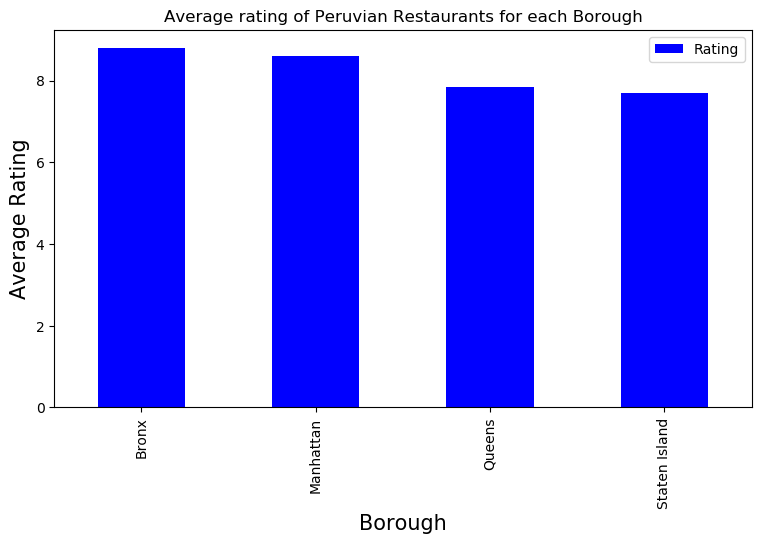

In [26]:
plt.figure(figsize=(9,5), dpi = 100)
plt.title('Average rating of Peruvian Restaurants for each Borough')
plt.xlabel('Borough', fontsize = 15)
plt.ylabel('Average Rating', fontsize=15)
peruvian_rest_stats_ny.groupby('Borough').mean()['Rating'].plot(kind='bar', color=clr)
plt.legend()
plt.show()

In [27]:
ny_neighborhood_stats=ny_neighborhood_stats[ny_neighborhood_stats['Average Rating']>=8.0]
ny_neighborhood_stats

,Neighborhood,Average Rating
0,Clinton,8.8
2,Hunters Point,8.5
3,Jackson Heights,8.0
4,Little Neck,8.7
5,Mott Haven,8.8
9,Upper West Side,8.4


In [28]:
ny_neighborhood_stats=pd.merge(ny_neighborhood_stats,ny_data, on='Neighborhood')
ny_neighborhood_stats=ny_neighborhood_stats[['Borough','Neighborhood','Latitude','Longitude','Average Rating']]
ny_neighborhood_stats

,Borough,Neighborhood,Latitude,Longitude,Average Rating
0,Manhattan,Clinton,40.759101,-73.996119,8.8
1,Queens,Hunters Point,40.743414,-73.953868,8.5
2,Queens,Jackson Heights,40.751981,-73.882821,8.0
3,Queens,Little Neck,40.770826,-73.738898,8.7
4,Bronx,Mott Haven,40.806239,-73.916100,8.8
5,Manhattan,Upper West Side,40.787658,-73.977059,8.4


In [29]:
# create map and display it
ny_map = folium.Map(location=geo_location('New York'), zoom_start=10)
# instantiate a feature group for the ratings in the dataframe
rating = folium.map.FeatureGroup()

# loop through the ratings and add each to the neighborhood feature group
for lat, lng, in ny_neighborhood_stats[['Latitude','Longitude']].values:
    rating.add_child(
        folium.CircleMarker(
            [lat, lng],
            radius=10, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )
ny_map

In [30]:
ny_neighborhood_stats['Label']=ny_neighborhood_stats['Neighborhood']+', '+ny_neighborhood_stats['Borough']+'('+ny_neighborhood_stats['Average Rating'].map(str)+')'
# add pop-up text to each marker on the map
for lat, lng, label in ny_neighborhood_stats[['Latitude','Longitude','Label']].values:
    folium.Marker([lat, lng], popup=label).add_to(ny_map)        
# add ratings to map
ny_map.add_child(rating)